In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#GlobalFinMonthly
url="https://raw.githubusercontent.com/amoreira2/Lectures/4b95c7d60e869dffa6367c1730183b68920ed2b9/assets/data/GlobalFinMonthly.csv"
Data = pd.read_csv(url,na_values=-99)
# tell python Date is date:
Data['Date']=pd.to_datetime(Data['Date'])
# set an an index
Data=Data.set_index(['Date'])
Data=Data.rename(columns={Data.columns[1]: "MKTUS",Data.columns[2]: "BondUS",
                          Data.columns[3]: "EM",Data.columns[4]: "MKTxUS",Data.columns[5]: "BondxUS" })
df=(Data.drop('RF',axis=1)).subtract(Data['RF'],axis='index')
df.tail()

,MKTUS,BondUS,EM,MKTxUS,BondxUS
Date,,,,,
2016-08-31,0.0050,-0.008617,0.024986,0.000638,-0.009752
2016-09-30,0.0025,-0.016617,0.012953,0.012536,0.009779
2016-10-31,-0.0202,-0.049660,0.002274,-0.020583,-0.043676
2016-11-30,0.0486,-0.081736,-0.046071,-0.019898,-0.050459
2016-12-31,0.0182,-0.005596,0.002604,0.034083,-0.023507


# Portfolio Optimization with constraints

* Another practical issue that practioners face is that MV analysis (in it's more pure form) does not account for several real world frictions that are more or less important depending on the investor:

 * Shorting an asset requires paying a borrowing fee to the owner of the asset. Shorting costs are sometimes prohibitive for small illiquid stocks
 
 * Most investors cannot really borrow at anything close to the risk-free rate--i.e., often they have to pay a substantially higher rate to borrow than to lend. 
 
* Python has the flexibility to solve the mean-variance problem numerically

* Allows you to impose realistic features to our portfolio problem 

  * Shorting costs
  * Borrowing costs higher than lending costs
  * Leverage constraints
  * Position limits due to investment mandates

Lets start by importing optimization package -- think of a much more powerful solver (excel)

In [5]:
from scipy.optimize import minimize

* we will now learn how to do a numerical minimization. 

* start by defining some useful variables

In [26]:
ERe=Re.mean()
print(ERe)
Cove=Re.cov()
print(Cove)

MKTUS      0.005140
BondUS     0.002523
EM         0.006923
MKTxUS     0.004149
BondxUS    0.002054
dtype: float64
            MKTUS    BondUS        EM    MKTxUS   BondxUS
MKTUS    0.001948  0.000111  0.001292  0.001264  0.000187
BondUS   0.000111  0.001227 -0.000204 -0.000013  0.000264
EM       0.001292 -0.000204  0.003556  0.001661  0.000249
MKTxUS   0.001264 -0.000013  0.001661  0.002182  0.000422
BondxUS  0.000187  0.000264  0.000249  0.000422  0.000407


**Modeling Borrowing limits**

In [38]:
# the risk-free rate is special because at a given time we know exactly what the expected returns of investing
# in it, since it is risk-free!
# so it does not make sense to use the average risk-free rate in the portfolio problem, and we should rather use the one that
# we currently can invest at no risk
# here we are dividing by 12 becasue we are using annualized numbers
rf=0.01/12
print(rf)

# below is the target for monthly expected returns
Ertarget=0.06/12
print(Ertarget)

# We pick a margin requirement
margin=0.5

0.0008333333333333334
0.005


* The program will choose a vector of weights that minimzies some function (of the chosen weights) subject to some constraint

* we need to provide an initial condition for these weights, which essentially tells python the shape of the variable that it is choosing. Here we will start with a equal weighted portfolio

* When solving minimization problems it is important to check that the exact initial conditions that you put in don't matter. 

* I mean, it's shape obviously matter, but whether is equal weighted or any other weighting scheme, the minimization should end up in the same place otherwise the numerical is not converging and you need to adjust the stop conditions

* We refer to this as making sure that you are finding a "global optimum" and not a "local optimum"

In [39]:
n=Re.shape[1]
W0=np.ones(n)/n 
W0


array([0.2, 0.2, 0.2, 0.2, 0.2])

**The objective function**

* We need to specify the function that our minimizer will try to minimize,i.e, our objective

* obviously this should be written as a function of the portfolio weights

* In this case it is the variance of a portfolio with weights W

* the weights will be our choice variable

* The minimization function will change the weights until this variance is minimized



In [40]:
# STEP 1: define the objective function, which is the variance of the portfolio in our case

def func(W,Cove=Re.cov()):
    return W @ Cove @ W


* Finally we need to specify the set of constraints that the minimization problem must satisfy

* you can specify two types of constraints: Equalities and inequalities.

* Equalities:
   * specified as 'eq' 
   * For example:`{'eq', 'fun' : lambda W : W.T @ (ERe+rf) +(1-W.sum())*rf-target}`
     * defines the function `F(W)=W @ (ERe+rf) +(1-W.sum())*rf-target`
     * and requires W to satisfy F(W)=0, i.e., `W @ (ERe+rf) +(1-W.sum())*rf=target`, or
     
     $$W'(ERe+rf) +(1-\sum w_i)rf=target$$
     
     * "target" here is the target for expected returns
     
* Inequalities:
   * specified as 'ineq'
   * For example: `{'ineq', 'fun' : lambda W: -W.sum()+1/margin}`
   * Defines  `F(W)=-W.sum()+1/margin`
   * and requires F(W)>=0, i.e.,
   
   $$\frac{1}{margin}\geq W.sum()$$
   
 It is useful to create a function that returns the expected returns of our portfolio given a weight choice

In [44]:
def expected_return(W):
     return W @ (ERe+rf) +(1-W.sum())*rf


In [45]:
# STEP 2: define constraint functions, we have two constraints: (1) target average return, and (2) leverage limit
Ertarget=0.12/12
cons=({'type': 'eq',
          'fun' : lambda W : expected_return(W)-Ertarget},
        {'type': 'ineq',
          'fun' : lambda W: -W.sum()+1/margin}) 


cons


({'type': 'eq', 'fun': <function __main__.<lambda>(W)>},
 {'type': 'ineq', 'fun': <function __main__.<lambda>(W)>})

* Finally we are ready to do our minimization
* `options={'disp': True}`: tell python to report intermediary steps so we can check if the algorithm is doing progress towards a solution.
* There is a variety of additional parameters that you can pass to the minimizer. 
* see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html


In [46]:
# STEP 3: solve the minimization problem with constraints and save as `sol`

sol = minimize(lambda x: func(x,Cove=Re.cov()),W0, constraints=cons, options={'disp': True})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.003404665865183952
            Iterations: 7
            Function evaluations: 42
            Gradient evaluations: 7


In [47]:
sol.x.sum()

2.0

In [22]:
# STEP 4: get the optimal portfolio weights

sol.x

array([ 0.58565363,  0.67667759,  0.69052641, -0.20448374,  0.25162612])

* Solution is saved in sol
* Lets plot the optimal weights

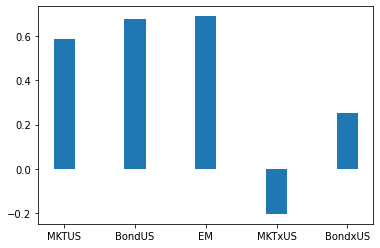

In [23]:

# below I am plotting the solution weights.
width=0.3
ind=np.arange(Re.shape[1])
fig, ax = plt.subplots()
ax.bar(ind,sol.x,width)

# ax.set_xticks(np.array([0,1,2,3,4,5])+ width / 2)
ax.set_xticks(ind)
ax.set_xticklabels(Re.columns)
plt.show()

* lets now introduce the realistic feature that you have to pya a spread to borrow on margin

* all we need to do is to change our expected return function
* And we need to redefine the constraints to they re updated
* I am setting a spread of 2%

In [63]:

def expected_return(W,spread):
     return W @ (ERe+rf) +(1-W.sum())*rf+ min(0,1-W.sum())*spread

def constraint(target,spread):
    cons=({'type': 'eq',
          'fun' : lambda W : expected_return(W,spread)-target},
        {'type': 'ineq',
          'fun' : lambda W: -W.sum()+1/margin}) 
    return cons

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.005671948276218396
            Iterations: 17
            Function evaluations: 119
            Gradient evaluations: 17


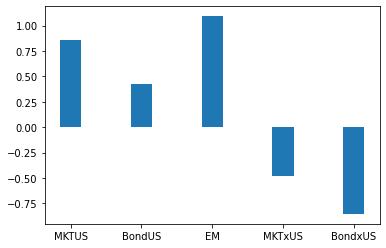

In [64]:
Ertarget=0.12/12
spread=0.02/12

sol = minimize(lambda x: func(x,Cove=Re.cov()),W0, constraints=constraint(Ertarget,spread), options={'disp': True})
width=0.3
ind=np.arange(Re.shape[1])
fig, ax = plt.subplots()
ax.bar(ind,sol.x,width)

# ax.set_xticks(np.array([0,1,2,3,4,5])+ width / 2)
ax.set_xticks(ind)
ax.set_xticklabels(Re.columns)
plt.show()

* What do you think will happen with the sum of weights as the spread increases?

* Suppose you increase this spread quite a bit, will a reduction in margin impact the optimal choice?

* When the margin is more likely to bind for an investor?

**Shorting**

* Lets now model shorting constraints

* We will mode shorting fees which can be scalar or a vector for each asset, we label this `sf`

* The shorting fee will be charge to any negative postion, hence `min(0,W)` which has value zero if the weight is positive

* We will also change the margin constraint to account for shorting margin by simply using the absolute value of your positions



In [88]:
margin=0.5
def expected_return(W,spread,sf):
     return W @ (ERe+rf) +(1-W.sum())*rf+ min(0,1-W.sum())*spread+(sf*np.minimum(0,W)).sum()

def constraint(target,spread,sf):
    cons=({'type': 'eq',
          'fun' : lambda W : expected_return(W,spread,sf)-target},
        {'type': 'ineq',
          'fun' : lambda W: -np.abs(W).sum()+1/margin}) 
    return cons

To focus on the role of shortign constraints let me start with the case of zero spread and lending fee

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0033237802440886253
            Iterations: 7
            Function evaluations: 42
            Gradient evaluations: 7


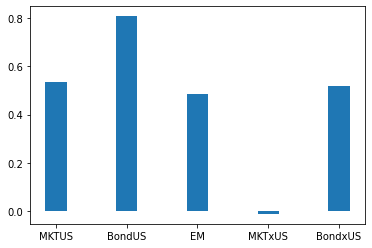

In [87]:
Ertarget=0.12/12
spread=0.0/12
sf=0

sol = minimize(lambda x: func(x,Cove=Re.cov()),W0, constraints=constraint(Ertarget,spread,sf), options={'disp': True})
width=0.3
ind=np.arange(Re.shape[1])
fig, ax = plt.subplots()
ax.bar(ind,sol.x,width)

# ax.set_xticks(np.array([0,1,2,3,4,5])+ width / 2)
ax.set_xticks(ind)
ax.set_xticklabels(Re.columns)
plt.show()

* You can do a multitude of different problems by making small changes to this code:

    * Borrowing at the risk-free rate is not allowed,  but lending is allowed
    * Shorting of any asset is not allowed
    * Shorting of some assets are not allowed
    * Shorting has an extra cost
    * Leverage is allowed, but borrowing rate is higher than risk-free rate
    

* How would you implement a hard shorting constraint?
 
* How would you implement no shorting of bonds, but allow investor to short equity markets (which can be done using futures)?